### Import Libs

In [340]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import DropConstantFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

### Load Data

In [341]:
df = pd.read_csv('../processed_data/features-target.csv')

In [342]:
df.head()

,machineID,dtRef,volt_mean_24h,volt_std_24h,volt_min_24h,volt_max_24h,volt_max_rate_24h,pressure_mean_24h,pressure_std_24h,pressure_min_24h,...,days_since_last_error,days_since_last_rep,model,age,count_comp2_last15days,count_comp4_last15days,count_comp3_last15days,count_comp1_last15days,avg_days_between_mtn,target
0,1,2015-02-02,164.947744,12.526438,142.559604,190.985830,1.120290,100.862632,7.021747,87.529260,...,5.833333,12.75,model3,18,0.0,0.0,0.0,0.0,33.285714,0.0
1,2,2015-02-02,167.388450,17.700100,135.350069,216.299453,1.268775,99.735153,9.236172,81.742015,...,20.416667,14.75,model4,7,0.0,0.0,0.0,0.0,54.000000,0.0
2,3,2015-02-02,166.065714,13.018281,139.126762,192.111761,1.126894,100.077484,12.097118,78.093179,...,4.291667,10.75,model3,8,0.0,0.0,0.0,0.0,44.000000,1.0
3,4,2015-02-02,173.652648,12.136008,152.527285,192.391288,1.128534,100.701927,10.328765,81.286954,...,16.750000,15.75,model3,7,0.0,0.0,0.0,0.0,53.750000,0.0
4,5,2015-02-02,167.550151,13.873202,140.783515,195.575448,1.147212,102.314697,12.696205,76.244390,...,1.208333,8.75,model3,2,0.0,0.0,0.0,0.0,32.400000,0.0


The creation of the dataset is described in the notebook "pdm-exploration-features.ipynb".

### Data Description

In [343]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

Number of rows: 31600
Number of columns: 37


In [344]:
df.dtypes

machineID                           int64
dtRef                              object
volt_mean_24h                     float64
volt_std_24h                      float64
volt_min_24h                      float64
volt_max_24h                      float64
volt_max_rate_24h                 float64
pressure_mean_24h                 float64
pressure_std_24h                  float64
pressure_min_24h                  float64
pressure_max_24h                  float64
pressure_max_rate_24h             float64
rotate_mean_24h                   float64
rotate_std_24h                    float64
rotate_min_24h                    float64
rotate_max_24h                    float64
rotate_max_rate_24h               float64
vibration_mean_24h                float64
vibration_std_24h                 float64
vibration_min_24h                 float64
vibration_max_24h                 float64
vibration_max_rate_24h            float64
volt_count_exceed_thr_24h         float64
pressure_count_exceed_thr_24h     

In [345]:
df.isna().sum()

machineID                            0
dtRef                                0
volt_mean_24h                        0
volt_std_24h                         0
volt_min_24h                         0
volt_max_24h                         0
volt_max_rate_24h                    0
pressure_mean_24h                    0
pressure_std_24h                     0
pressure_min_24h                     0
pressure_max_24h                     0
pressure_max_rate_24h                0
rotate_mean_24h                      0
rotate_std_24h                       0
rotate_min_24h                       0
rotate_max_24h                       0
rotate_max_rate_24h                  0
vibration_mean_24h                   0
vibration_std_24h                    0
vibration_min_24h                    0
vibration_max_24h                    0
vibration_max_rate_24h               0
volt_count_exceed_thr_24h            0
pressure_count_exceed_thr_24h        0
rotate_count_exceed_thr_24h          0
vibration_count_exceed_th

The variable "days_since_last_error/failure" should indicate if a variable had an error before or not. So, since it has nan values, we can assume machines that didn't have errors or failures and this value should be very high. This is a consideration for the pre-processing part.

In [346]:
df.describe()

,machineID,volt_mean_24h,volt_std_24h,volt_min_24h,volt_max_24h,volt_max_rate_24h,pressure_mean_24h,pressure_std_24h,pressure_min_24h,pressure_max_24h,...,days_since_last_failure,days_since_last_error,days_since_last_rep,age,count_comp2_last15days,count_comp4_last15days,count_comp3_last15days,count_comp1_last15days,avg_days_between_mtn,target
count,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,...,29908.000000,31580.000000,31600.000000,31600.000000,31600.0,31600.0,31600.0,31600.0,31600.000000,31600.000000
mean,50.500000,170.760869,14.912348,141.446891,200.167114,1.174146,100.849249,10.053176,81.112933,120.645158,...,41.273556,9.717854,9.460032,11.330000,0.0,0.0,0.0,0.0,23.125695,0.151424
std,28.866527,4.722131,2.257656,8.309407,8.726679,0.051189,4.705546,1.718139,6.258213,7.246184,...,42.545864,9.332403,7.166314,5.827708,0.0,0.0,0.0,0.0,7.764057,0.358467
min,1.000000,157.745683,7.383772,97.333604,176.709005,1.036544,90.973896,4.513850,51.237106,101.486195,...,0.750000,0.000000,0.750000,0.000000,0.0,0.0,0.0,0.0,12.571429,0.000000
25%,25.750000,168.036829,13.343677,136.396166,194.093201,1.138517,98.682687,8.924697,77.553506,116.058943,...,12.750000,2.875000,4.750000,6.750000,0.0,0.0,0.0,0.0,18.066667,0.000000
50%,50.500000,170.191852,14.836994,141.811621,199.141258,1.168128,100.114529,9.921164,81.210152,119.372650,...,28.750000,6.875000,8.750000,12.000000,0.0,0.0,0.0,0.0,20.705882,0.000000
75%,75.250000,172.472412,16.413043,146.792443,204.924431,1.202051,101.614597,10.988817,84.409845,123.341198,...,53.750000,13.583333,12.750000,16.000000,0.0,0.0,0.0,0.0,25.555556,0.000000
max,100.000000,218.265191,26.725027,191.645382,255.124717,1.496518,152.314600,28.399538,136.619446,185.951998,...,292.750000,79.000000,157.750000,20.000000,0.0,0.0,0.0,0.0,70.000000,1.000000


The idea here is the pre-processing and modeling part. So, I will not take into account all other steps.

### Split Train / OOT

In [347]:
df_train = df[df['dtRef'] <= '2015-11-30']

df_oot = df[df['dtRef'] > '2015-11-30']

The idea here is to separate our database in 2 things: Train and Test on new data.

- Train dataset is used to TRAIN and VALIDATE our model, to do so, I will consider the examples before december.
- Out of Time dataset is used only to TEST our model in data that is never seen by the model. This split is considered only after december.

### Pre-Processing

Since we have seen before, random sampling for cross-sectional data doesn't work well to have a good validation. To separate the data in train and test, it is necessary to have the same machine ID in the same group of validation and training. To do so, we generate a random sample and 70% are in the training group and 30% are in the testing group. 

In [348]:
df_ids = df_train[['machineID']].drop_duplicates()
np.random.seed(42)
df_ids['wookie'] = (np.random.randint(0, 10000, df_ids.shape[0]))/10000
df_ids=df_ids[['machineID', 'wookie']]

In [349]:
df_ids['MODELING_GROUP'] = np.where(((df_ids.wookie <= 0.7)), 'TRAINING', 'VALIDATION')
df_ids

,machineID,wookie,MODELING_GROUP
0,1,0.7270,VALIDATION
1,2,0.0860,TRAINING
2,3,0.5390,TRAINING
3,4,0.5191,TRAINING
4,5,0.5734,TRAINING
...,...,...,...
95,96,0.6736,TRAINING
96,97,0.0391,TRAINING
97,98,0.5892,TRAINING
98,99,0.3561,TRAINING


In [350]:
df_ids.groupby('MODELING_GROUP')['wookie'].count()

MODELING_GROUP
TRAINING      68
VALIDATION    32
Name: wookie, dtype: int64

In [351]:
df_train = pd.merge(df_train, df_ids[['machineID', 'MODELING_GROUP']], on = 'machineID', how = 'left').sort_values(['machineID', 'dtRef'])

In [384]:
# Split the dataset in train and test
X_train, y_train = df_train[df_train['MODELING_GROUP'] == 'TRAINING'].drop(['target', 'MODELING_GROUP'], axis = 1), df_train[df_train['MODELING_GROUP'] == 'TRAINING'][['target']] 
X_val, y_val = df_train[df_train['MODELING_GROUP'] == 'VALIDATION'].drop(['target', 'MODELING_GROUP'], axis = 1), df_train[df_train['MODELING_GROUP'] == 'VALIDATION'][['target']] 


In [385]:
X_train_ids = X_train[['dtRef', 'machineID']]
X_val_ids = X_val[['dtRef', 'machineID']]


X_train = X_train.drop(['dtRef', 'machineID'], axis = 1)
X_val = X_val.drop(['dtRef', 'machineID'], axis = 1)

In [354]:
# Conver values to integer instead of float
y_train = y_train.astype(int)
y_val = y_val.astype(int)

In [355]:
print('X_train:', X_train.shape)
print('X_val:', X_val.shape)
print('y_train:', y_train.shape)
print('y_val:', y_val.shape)

X_train: (20536, 34)
X_val: (9664, 34)
y_train: (20536, 1)
y_val: (9664, 1)


In [356]:
# Target proportion
y_train.value_counts(normalize = True)

target
0         0.852211
1         0.147789
Name: proportion, dtype: float64

In [357]:
# Target proportion
y_val.value_counts(normalize = True)

target
0         0.84137
1         0.15863
Name: proportion, dtype: float64

In [358]:
# Numerical features to be pre-processed by the pipeline
numeric_features = ['volt_mean_24h', 'volt_std_24h', 'volt_min_24h',
       'volt_max_24h', 'volt_max_rate_24h', 'pressure_mean_24h',
       'pressure_std_24h', 'pressure_min_24h', 'pressure_max_24h',
       'pressure_max_rate_24h', 'rotate_mean_24h', 'rotate_std_24h',
       'rotate_min_24h', 'rotate_max_24h', 'rotate_max_rate_24h',
       'vibration_mean_24h', 'vibration_std_24h', 'vibration_min_24h',
       'vibration_max_24h', 'vibration_max_rate_24h',
       'volt_count_exceed_thr_24h', 'pressure_count_exceed_thr_24h',
       'rotate_count_exceed_thr_24h', 'vibration_count_exceed_thr_24h',
       'days_since_last_failure', 'days_since_last_error',
       'days_since_last_rep', 'age', 'count_comp2_last15days',
       'count_comp4_last15days', 'count_comp3_last15days',
       'count_comp1_last15days', 'avg_days_between_mtn']

# Categorical features to be pre-processed by the pipeline
categorical_features = ['model']

# The response
target = 'target'

# Features to fill missing values
imputer_features = ['days_since_last_failure', 'days_since_last_error']

# Imputer transformation
imputer_transformer = Pipeline(
    steps=[("imputer", ArbitraryNumberImputer(arbitrary_number=10000))]
)

# Numerical transformations
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)

# Categorical transformations
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder())
]
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough'
    
)


### Feature Selection

In [359]:
smart_corr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.7,
    missing_values="raise",
    selection_method="variance"
)

In [360]:
feat_selector_pipe = Pipeline([
    ('imputer', ArbitraryNumberImputer(arbitrary_number=10000, variables = imputer_features)),
    ('preprocessor', preprocessor),
    ('selector_cte', DropConstantFeatures()),
    ('selector_corr', smart_corr)
])


df_feat = feat_selector_pipe.fit_transform(X_train, y_train)

c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))


In [361]:
all_vars = list(feat_selector_pipe['preprocessor'].get_feature_names_out())
idx = [int(x[1:]) for x in df_feat.columns]

selected_features = [all_vars[i].split('__')[1] for i in idx]

print("Features:", selected_features)
print("Number of Selected Features:", len(selected_features))

Features: ['volt_mean_24h', 'volt_std_24h', 'volt_min_24h', 'volt_max_24h', 'pressure_std_24h', 'pressure_min_24h', 'pressure_max_24h', 'rotate_mean_24h', 'rotate_std_24h', 'rotate_min_24h', 'rotate_max_rate_24h', 'vibration_mean_24h', 'vibration_std_24h', 'vibration_min_24h', 'vibration_max_rate_24h', 'volt_count_exceed_thr_24h', 'rotate_count_exceed_thr_24h', 'days_since_last_failure', 'days_since_last_error', 'days_since_last_rep', 'age', 'avg_days_between_mtn', 'model_model4', 'model_model3', 'model_model2', 'model_model1']
Number of Selected Features: 26


### Modeling

In [362]:
def evaluate(y_true, y_pred_prob, threshold = 0.5):
    # convert probabilities to binary predictions
    y_pred = (y_pred_prob > threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("ROC-AUC:", roc_auc)
    

In [363]:
model = CatBoostClassifier(random_state = 42,
                           n_estimators = 300,
                           depth = 3,
                           reg_lambda = 4,
                           verbose = False)


model_pipe = Pipeline([
                        ('imputer', ArbitraryNumberImputer(arbitrary_number=10000, variables = imputer_features)),
                        ('preprocessor', preprocessor),
                        ('selector_cte', DropConstantFeatures()),
                        ('selector_corr', smart_corr),
                        ('model', model)
                        ])

model_pipe.fit(X_train, y_train)

c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))


Pipeline(steps=[('imputer',
                 ArbitraryNumberImputer(arbitrary_number=10000,
                                        variables=['days_since_last_failure',
                                                   'days_since_last_error'])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['volt_mean_24h',
                                                   'volt_std_24h',
                                                   'volt_min_24h',
                                                   'volt_max_24h',
                                                   'volt_max_rate_24h',
                                                   'pressur...
                                                   'days_since_last_rep', 'age',
                                                   'count_comp2_last15days',
                                                   'count_comp4_last15days', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['model'])])),
                ('selector_cte', DropConstantFeatures()),
                ('selector_corr',
                 SmartCorrelatedSelection(missing_values='raise',
                                          selection_method='variance',
                                          threshold=0.7)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x00000250DE594550>)])

In [377]:
y_train_pred = model_pipe.predict_proba(X_train)[:, 1]
y_val_pred = model_pipe.predict_proba(X_val)[:, 1]
y_oot_pred = model_pipe.predict_proba(df_oot.drop(['dtRef', 'machineID', 'target'], axis = 1))[:, 1]

In [365]:
print('Training:')
evaluate(y_train, y_train_pred, threshold = 0.5)
print('\n')
print('Validation:')
evaluate(y_val, y_val_pred, threshold = 0.5)
print('\n')
print('Out of Time:')
evaluate(df_oot['target'], y_oot_pred, threshold = 0.5)

Training:
Accuracy: 0.8823529411764706
Precision: 0.873341375150784
Recall: 0.2385502471169687
F1-score: 0.3747412008281573
ROC-AUC: 0.9150877045670348


Validation:
Accuracy: 0.8693087748344371
Precision: 0.8571428571428571
Recall: 0.21135029354207435
F1-score: 0.3390894819466248
ROC-AUC: 0.8981670257170921


Out of Time:
Accuracy: 0.86
Precision: 0.6909090909090909
Recall: 0.17511520737327188
F1-score: 0.27941176470588236
ROC-AUC: 0.8664061921771955


In [210]:
from sklearn.metrics import confusion_matrix

In [211]:
y_val_pred

array([0.238439  , 0.15155798, 0.08134151, ..., 0.0071668 , 0.00793148,
       0.00862463])

In [212]:
confusion_matrix(y_val.values, (y_val_pred > 0.5))

# TP FN
# FP TN

array([[8077,   54],
       [1209,  324]], dtype=int64)

Each failure is represented 7 times. If a machine fails on sunday, it will be flagged the whole previous week (7 days window). To decrease the number of false alarms, it is necessary to do a post-processing removing the redundant failure signals. We need to ensure that at least some period exist between each failure signal.
The minimum time between failures is about 20 days, so we ensure this period.

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt

In [514]:
df_failures = pd.read_csv('../data/PdM_failures.csv')
df_failures['dtRef'] = df_failures['datetime'].apply(lambda x: x.split(' ')[0])
df_failures = df_failures[['dtRef', 'machineID']].drop_duplicates()
df_failures['real_failure'] = 1


In [525]:
X_train_ids = pd.merge(X_train_ids, df_failures, on = ['machineID', 'dtRef'], how = 'left')
X_val_ids = pd.merge(X_val_ids, df_failures, on = ['machineID', 'dtRef'], how = 'left')
X_oot_ids = pd.merge(df_oot[['dtRef', 'machineID']], df_failures, on = ['machineID', 'dtRef'], how = 'left')

In [527]:
X_train_ids = X_train_ids.fillna(0)
X_val_ids = X_val_ids.fillna(0)
X_oot_ids = X_oot_ids.fillna(0)

In [539]:
threshold = 0.7

y_train_pp = X_train_ids.copy()
#y_train_pp = pd.concat([y_train_pp, y_train], axis = 1)
y_train_pp['pred'] = (y_train_pred > threshold).astype(int)
y_train_pp['pred_prob'] = y_train_pred

y_val_pp = X_val_ids.copy()
#y_val_pp = pd.concat([y_val_pp, y_val], axis = 1)
y_val_pp['pred'] = (y_val_pred > threshold).astype(int)
y_val_pp['pred_prob'] = y_val_pred


y_oot_pp = X_oot_ids.copy()
#y_val_pp = pd.concat([y_val_pp, y_val], axis = 1)
y_oot_pp['pred'] = (y_oot_pred > threshold).astype(int)
y_oot_pp['pred_prob'] = y_oot_pred


In [540]:
forecast_window = 14
df_train_machine_total = pd.DataFrame()
for machine in y_train_pp['machineID'].unique():
    df_train_machine = y_train_pp[y_train_pp['machineID'] == machine].sort_values('dtRef')
    df_train_machine['pred_sum'] =(df_train_machine['pred'].rolling(min_periods=1, window=(forecast_window)).sum())
    df_train_machine_total = pd.concat([df_train_machine_total, df_train_machine], axis = 0)
    
df_train_machine_total['real_pred']=np.where((df_train_machine_total.pred_sum>1), 0, df_train_machine_total.pred)



df_val_machine_total = pd.DataFrame()
for machine in y_val_pp['machineID'].unique():
    df_val_machine = y_val_pp[y_val_pp['machineID'] == machine].sort_values('dtRef')
    df_val_machine['pred_sum'] =(df_val_machine['pred'].rolling(min_periods=1, window=(forecast_window)).sum())
    df_val_machine_total = pd.concat([df_val_machine_total, df_val_machine], axis = 0)
    
df_val_machine_total['real_pred']=np.where((df_val_machine_total.pred_sum>1), 0, df_val_machine_total.pred)



df_oot_machine_total = pd.DataFrame()
for machine in y_oot_pp['machineID'].unique():
    df_oot_machine = y_oot_pp[y_oot_pp['machineID'] == machine].sort_values('dtRef')
    df_oot_machine['pred_sum'] =(df_oot_machine['pred'].rolling(min_periods=1, window=(forecast_window)).sum())
    df_oot_machine_total = pd.concat([df_oot_machine_total, df_oot_machine], axis = 0)
    
df_oot_machine_total['real_pred']=np.where((df_oot_machine_total.pred_sum>1), 0, df_oot_machine_total.pred)

In [541]:
df_oot_machine_total

,dtRef,machineID,real_failure,pred,pred_prob,pred_sum,real_pred
0,2015-12-01,1,0.0,0,0.075991,0.0,0
100,2015-12-02,1,0.0,0,0.005119,0.0,0
200,2015-12-03,1,0.0,0,0.007342,0.0,0
300,2015-12-04,1,0.0,0,0.004935,0.0,0
400,2015-12-05,1,0.0,0,0.003685,0.0,0
...,...,...,...,...,...,...,...
999,2015-12-10,100,0.0,0,0.002169,1.0,0
1099,2015-12-11,100,0.0,0,0.002307,1.0,0
1199,2015-12-12,100,0.0,0,0.002388,1.0,0
1299,2015-12-13,100,0.0,0,0.002194,1.0,0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 [Text(0, 0, '2015-02-02'),
  Text(1, 0, '2015-02-03'),
  Text(2, 0, '2015-02-04'),
  Text(3, 0, '2015-02-05'),
  Text(4, 0, '2015-02-06'),
  Text(5, 0, '2015-02-07'),
  Text(6, 0, '2015-02-08'),
  Text(7, 0, '2015-02-09'),
  Text(8, 0, '2015-02-10'),
  Text(9, 0, '2015-02-11'),
  Text(10, 0, '2015-02-12'),
  Text(11, 0, '2015-02-13'),
  Text(12, 0, '2015-02-14'),
  Text(13, 0, '2015-02-15'),
  Text(14, 0, '2015-02-16'),
  Text(15, 0, '2015-02-17'),
  Text(16, 0, '2015-02-18'),
  Text(17, 0, '2015-02-19'),
  Text(18, 0, '2015-02-20'),
  Text(19, 0, '2015-02-21'),
  Text(20, 0, '2015-02-22'),
  Text(21, 0, '2015-02-23'),
  Text(22, 0, '2015-02-24'),
  Text(23, 0, '2015-02-25'),
  Text(24, 0, '2015-02-26'),
  Text(25, 0, '2015-02-27'),
  Text(26, 0, '2015-02-28'),
  Text(27, 0, '2015-03-01'),
  Text(28, 0

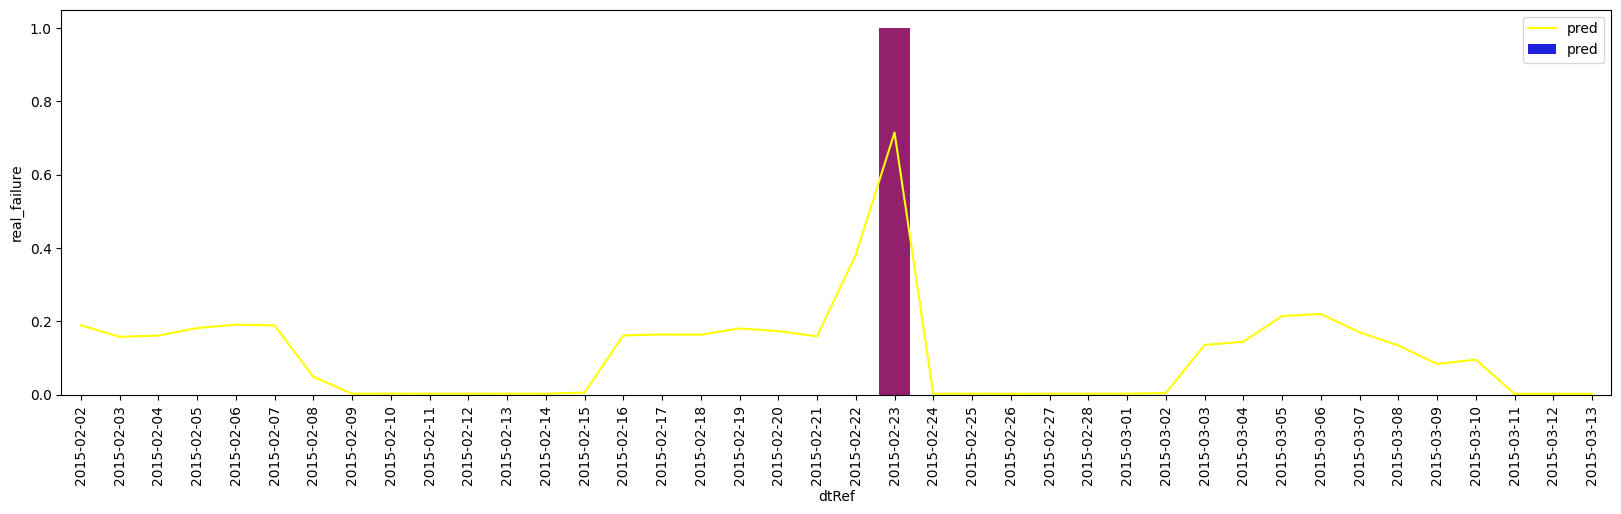

In [544]:
plt.figure(1, figsize = (20,5))
sns.barplot(x = 'dtRef', y = 'real_pred', data = df_train_machine_total[df_train_machine_total['machineID'] == 5].iloc[:40], label = 'pred', color = 'blue')
sns.lineplot(x = 'dtRef', y = 'pred_prob', data = df_train_machine_total[df_train_machine_total['machineID'] == 5].iloc[:40], label = 'pred', color = 'yellow')
sns.barplot(x = 'dtRef', y = 'real_failure', data = df_train_machine_total[df_train_machine_total['machineID'] == 5].iloc[:40], label = 'target', color = 'red', alpha = 0.6)
plt.xticks(rotation=90)

In [508]:
confusion_matrix(df_val_machine_total['real_failure'].values, df_val_machine_total['real_pred'].values)

# TN FP
# FN TP

array([[9442,   25],
       [  44,  153]], dtype=int64)

Great. We achieved a reduction of 1209 False Positives to 105! This will reduce a lot the number of false alarms in the system.

In [531]:
print('Training:')
evaluate(df_train_machine_total['real_failure'].values, df_train_machine_total['real_pred'].values, threshold = threshold)
print('\n')
print('Validation:')
evaluate(df_val_machine_total['real_failure'].values, df_val_machine_total['real_pred'].values, threshold = threshold)
print('\n')
print('Out of Time:')
evaluate(df_oot_machine_total['real_failure'].values, df_oot_machine_total['real_pred'].values, threshold = threshold)


Training:
Accuracy: 0.9903583950136345
Precision: 0.7578347578347578
Recall: 0.7018469656992085
F1-score: 0.7287671232876713
ROC-AUC: 0.8488150341717255


Validation:
Accuracy: 0.9928600993377483
Precision: 0.8595505617977528
Recall: 0.7766497461928934
F1-score: 0.8160000000000001
ROC-AUC: 0.8870044970533496


Out of Time:
Accuracy: 0.995
Precision: 0.8636363636363636
Recall: 0.8260869565217391
F1-score: 0.8444444444444444
ROC-AUC: 0.9119541536421332


<Axes: xlabel='dtRef', ylabel='real_failure'>

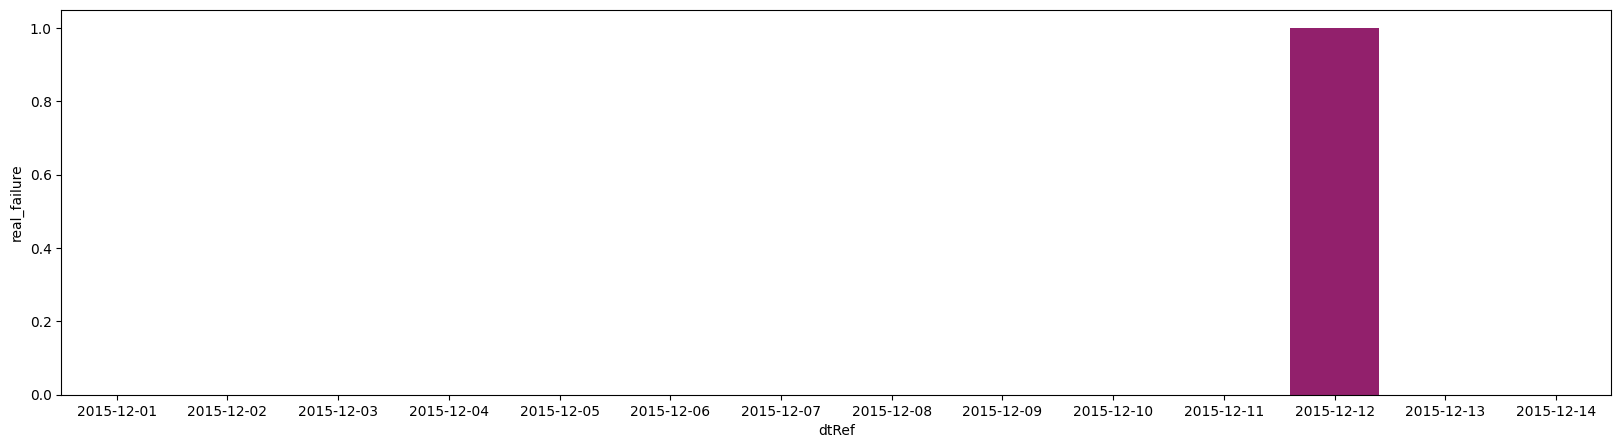

In [536]:
plt.figure(1, figsize = (20,5))
sns.barplot(x = 'dtRef', y = 'real_pred', data = df_oot_machine_total[df_oot_machine_total['machineID'] == 51], label = 'pred', color = 'blue')
sns.barplot(x = 'dtRef', y = 'real_failure', data = df_oot_machine_total[df_oot_machine_total['machineID'] == 51], label = 'target', color = 'red', alpha = 0.6)
#plt.xticks(rotation=90)

### Next Steps:

- Add warning 
- Correction of validation with Warning